In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [31]:
plt.style.use('dark_background')

# Read in edu pos 4 week olfactory bulb

In [32]:
edu_4_week_ob_scdata = sc.read_h5ad(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\4week_mouse_edu_labeled_onlyOB.h5ad")
edu_4_week_ob_scdata

AnnData object with n_obs × n_vars = 49170 × 275
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'edu_median', 'edu_mean', 'edu_pos', 'leiden', 'celltype', 'x'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'x_colors'
    obsm: 'X_raw', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

# Subset for only edu pos cells

In [33]:
edu_pos_scdata = edu_4_week_ob_scdata[edu_4_week_ob_scdata.obs['edu_pos'] == '1']
edu_pos_scdata

View of AnnData object with n_obs × n_vars = 5143 × 275
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'edu_median', 'edu_mean', 'edu_pos', 'leiden', 'celltype', 'x'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'x_colors'
    obsm: 'X_raw', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

# Generate umap

### Select parameters for umap

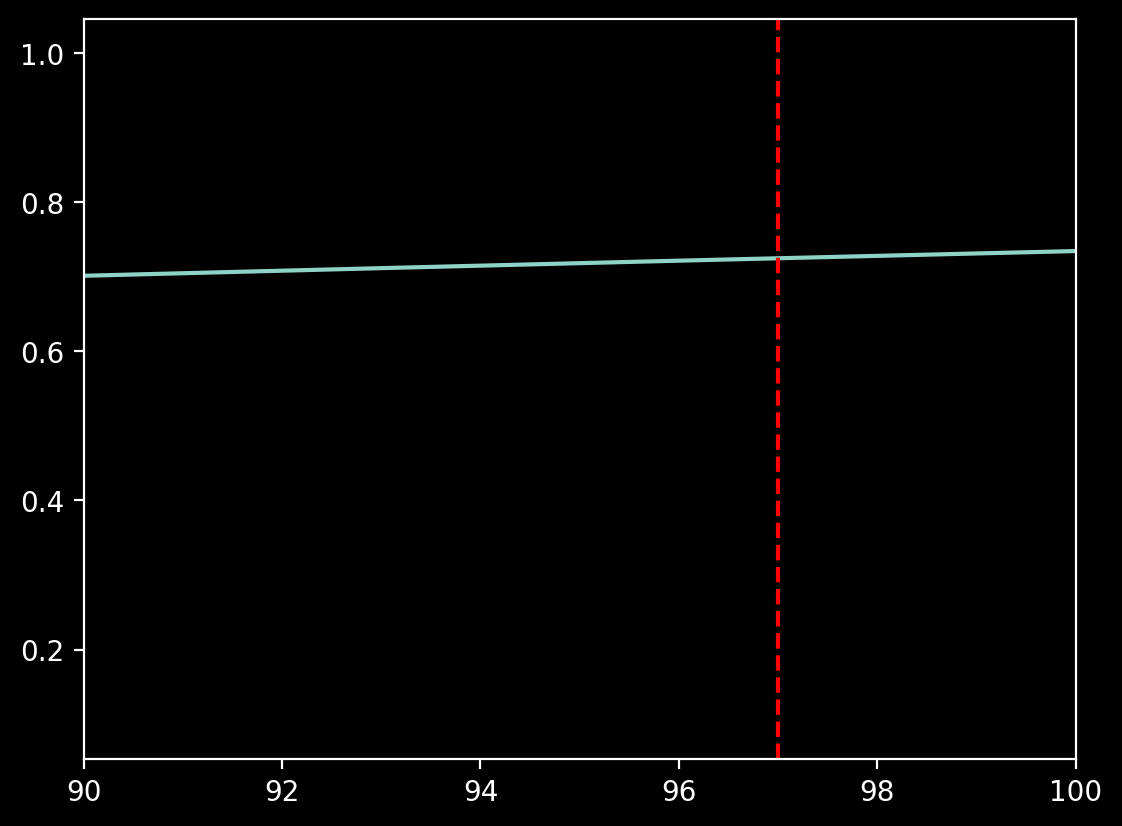

In [44]:
# find elbow point for optimal number of dimensions
dimred = PCA()
dimred.fit(edu_pos_scdata.X)
sns.lineplot(np.cumsum(dimred.explained_variance_ratio_))
location = KneeLocator(range(1, len(dimred.explained_variance_ratio_) + 1),
                       np.cumsum(dimred.explained_variance_ratio_),
                       curve="concave", direction="increasing")
plt.axvline(location.elbow, color="red", linestyle="--")
plt.xlim((90,100));

In [47]:
# do 97 dimensions
sc.pp.pca(edu_pos_scdata, n_comps = 97)

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarnin

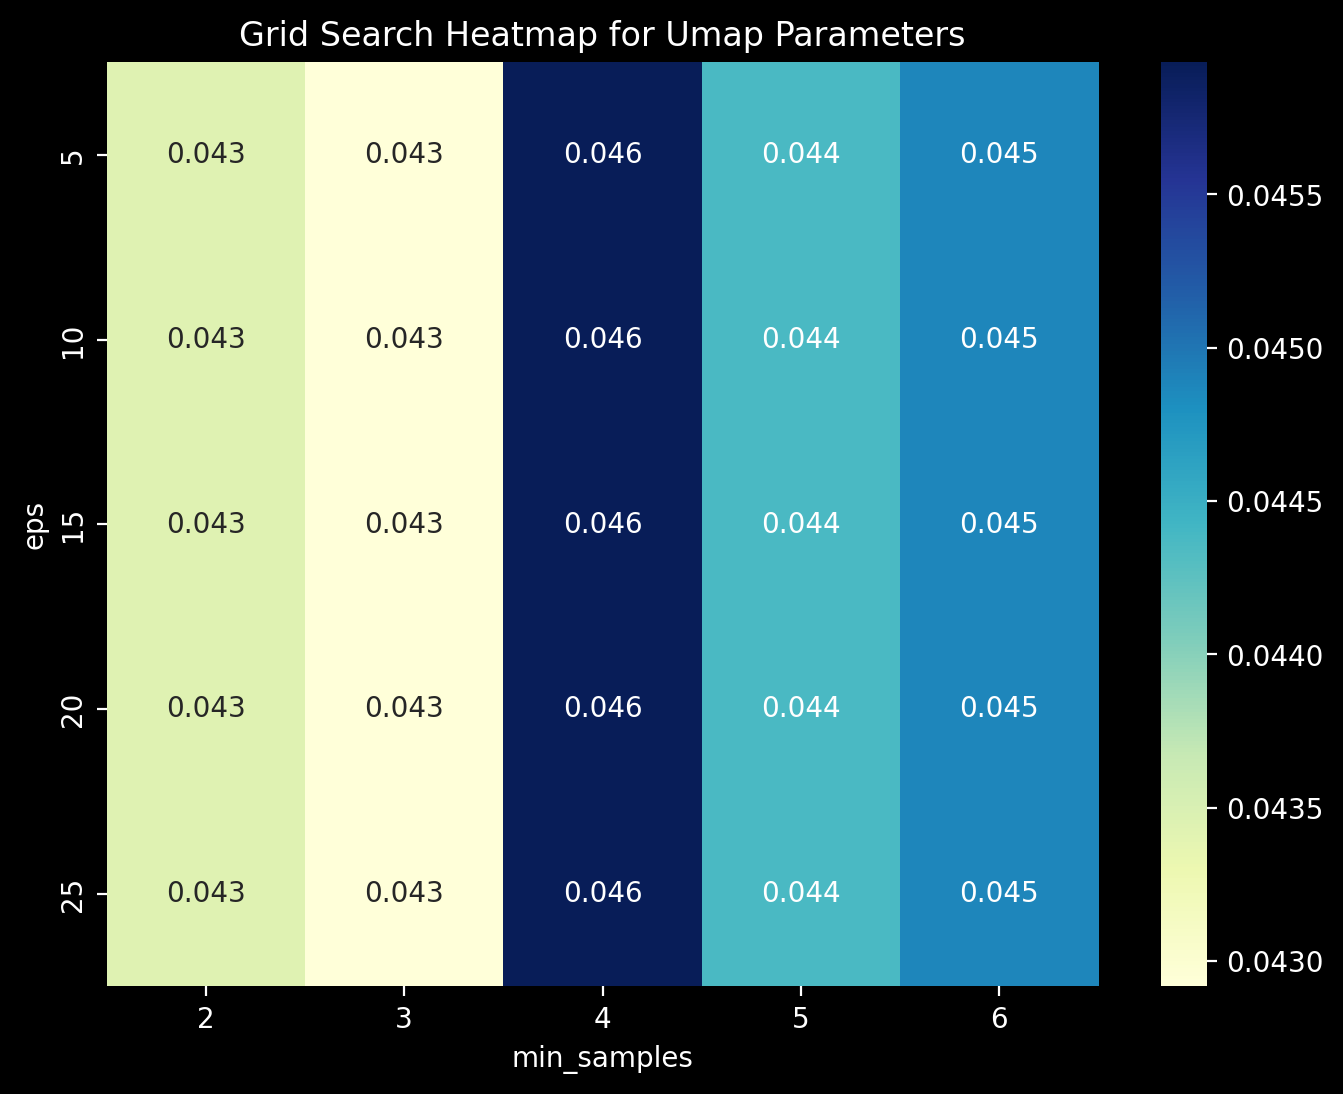

In [46]:
# find optimal parameters for umap using gridsearch
param_grid = {'n_components':[2,3,4,5,6],
              'n_neighbors' : [5, 10, 15, 20, 25]}
# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['n_components']), len(param_grid['n_components'])))
for i, params in enumerate(ParameterGrid(param_grid)):
    sc.pp.pca(edu_pos_scdata, n_comps = 97)
    umap_operator = umap.UMAP(n_components = params['n_components'], random_state = 42)
    umap_result = umap_operator.fit_transform(edu_pos_scdata.obsm['X_pca'])
    edu_pos_scdata.obsm['X_umap'] = umap_result
    sc.pp.neighbors(edu_pos_scdata, n_neighbors = params['n_neighbors'])
    sc.tl.leiden(edu_pos_scdata, resolution = 0.5)
    silhouette_avg = silhouette_score(edu_pos_scdata.obsm['X_pca'], edu_pos_scdata.obs['leiden'])
    silhouette_scores[i // len(param_grid['n_components']), i % len(param_grid['n_neighbors'])] = silhouette_avg
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['n_components'], yticklabels=param_grid['n_neighbors'])
plt.xlabel('n_components')
plt.ylabel('n_neighbors')
plt.title('Grid Search Heatmap for Umap Parameters')
plt.show()

In [51]:
umap_operator = umap.UMAP(n_components = 3, random_state = 42, metric = 'euclidean')
umap_result_edupos = umap_operator.fit_transform(edu_pos_scdata.obsm['X_pca'])

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [52]:
edu_pos_scdata.obsm['X_umap'] = umap_result_edupos

In [68]:
sc.pp.neighbors(edu_pos_scdata)
sc.tl.leiden(edu_pos_scdata, resolution = 1.25)

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


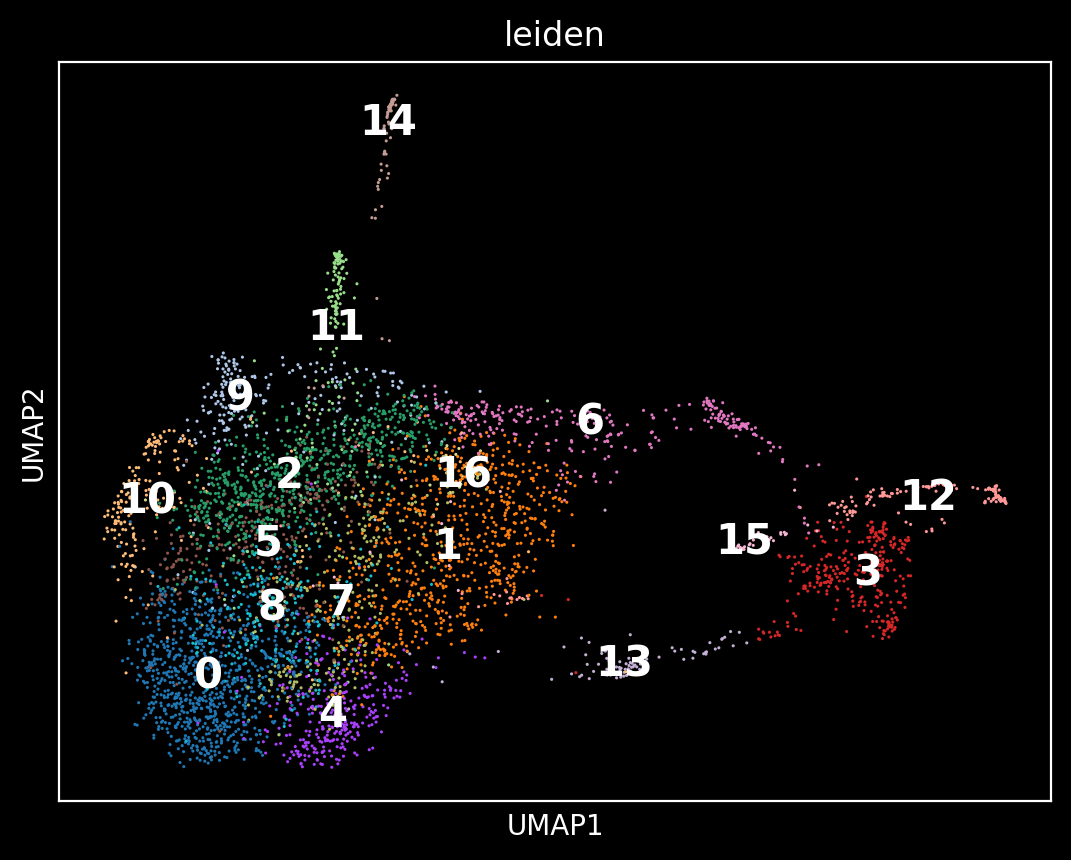

In [69]:
sc.pl.umap(edu_pos_scdata, color = 'leiden', legend_loc = 'on data', size = 5, legend_fontsize = 15)

In [62]:
# read in allen brain atlas for comparison
aba = pd.read_csv(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\allen_brain_atlas_trimmed_means.csv")
aba_column_list = list(aba.columns)
aba_column_list_revised = ['feature']
for i in range(1,len(aba_column_list)):
    aba_column_list_revised.append(aba_column_list[i].split('_')[1])
aba.columns = aba_column_list_revised
#aba.to_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\allen_brain_atlas_trimmed_means.csv", index = False)
aba

,feature,Pvalb,L6 IT CTX,Ntng1 HPF,Sst,Lamp5 Lhx6,Pvalb,CA2-IG-FC,Car3,CA1-do,...,Vip,L4/5 IT CTX,L5/6 IT CTX,CA1,L5 PT CTX,ProS,L4 IT CTX,L6 CT CTX,Astro,L6 CT ENT
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0610007P14Rik,6.149091,6.844643,6.503429,6.368064,6.716667,6.123093,6.8675,7.097313,6.410685,...,6.494454,6.175000,6.520834,6.937000,6.227551,6.77750,6.451691,6.607911,7.525000,6.529638
3,0610009B22Rik,6.393636,6.366785,6.951667,6.568254,6.811984,6.551165,5.9700,6.389925,6.239452,...,6.431515,5.994375,6.242500,6.505333,6.221458,6.59125,6.113125,6.669403,1.761538,6.052993
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.085833,0.000000,0.000000,0.000000,0.05200,0.000000,0.077822,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45763,n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
45764,n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
45765,n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
45766,n-R5s146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [63]:
def generate_cell_type(scdata, ref_df):
    sc.tl.rank_genes_groups(scdata, groupby = 'leiden', method = 'wilcoxon', use_raw = False)
    
    gene_expression_df = pd.DataFrame()
    for cluster in scdata.obs['leiden'].cat.categories:
        cluster_gene_name = scdata.uns['rank_genes_groups']['names'][cluster]
        cluster_gene_score = scdata.uns['rank_genes_groups']['scores'][cluster]
        gene_expression_df[cluster] = {key: val for key, val in zip(cluster_gene_name, cluster_gene_score)}

    gene_expression_df.index = gene_expression_df.index.map(str.capitalize)
    gene_expression_df = gene_expression_df.T
    
    genes_list = gene_expression_df.columns.tolist()
    
    #comparison_df = ref_df[ref_df['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature')
    comparison_df = ref_df[ref_df['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature').T
    comparison_df = comparison_df.groupby(comparison_df.index).mean().T
    
    gene_expression_df_postprocessed = gene_expression_df.loc[:, gene_expression_df.columns.isin(comparison_df.index)]
    
    update_list_genes = np.array(gene_expression_df_postprocessed.columns)
    
    scdata_subset = scdata[:, scdata.var_names.isin(update_list_genes)].copy()
    
    scdata_subset.X_expand = scdata_subset.X#.toarray()
    
    X_MERFISH_zscored = zscore(scdata_subset.X_expand, axis=0)
    clusters = scdata_subset.obs['leiden']
    uclusters = np.unique(clusters)
    X_MERFISH_zscored_per_cluster = np.array([np.mean(X_MERFISH_zscored[cl==clusters],axis=0) for cl in uclusters])

    #X_seq = np.array(comparison_df.iloc[:,1:]).T
    X_seq = np.array(comparison_df.iloc[:,0:]).T
    X_seq[np.isnan(X_seq)]=0
    X_seq_zscored = zscore(X_seq,axis=0)
    X_seq_zscored[np.isnan(X_seq_zscored)]=0
    
    Mcor = [[np.corrcoef(clMER,clSEQ)[0,1] for clSEQ in X_seq_zscored] for clMER in X_MERFISH_zscored_per_cluster]
    
    #names_seq = list(comparison_df.keys())[1:]
    names_seq = list(comparison_df.keys())[0:]
    
    Mcor_t = np.array(Mcor).T
    
    plt.style.use('dark_background')
    #plt.figure(figsize=(120,200))
    plt.figure(figsize=(15,25))
    #plt.imshow(xenium_Mcor,cmap='bwr')
    plt.imshow(Mcor_t,cmap='bwr')
    plt.yticks(np.arange(len(names_seq)),names_seq,rotation=35,ha='right');
    #plt.yticks(np.arange(len(uclusters)),[(ucl,dic_rename[ucl])for ucl in uclusters]);
    plt.xticks(np.arange(len(uclusters)),uclusters)
    plt.xlabel('Cell Clusters from our MERFISH in mouse cortex', size=30)
    plt.ylabel('Cell Clusters from sn-RNASeq in mouse cortex \n(Allan Brian Atlas)', size=30);
    plt.tick_params(axis='x', top=True)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')

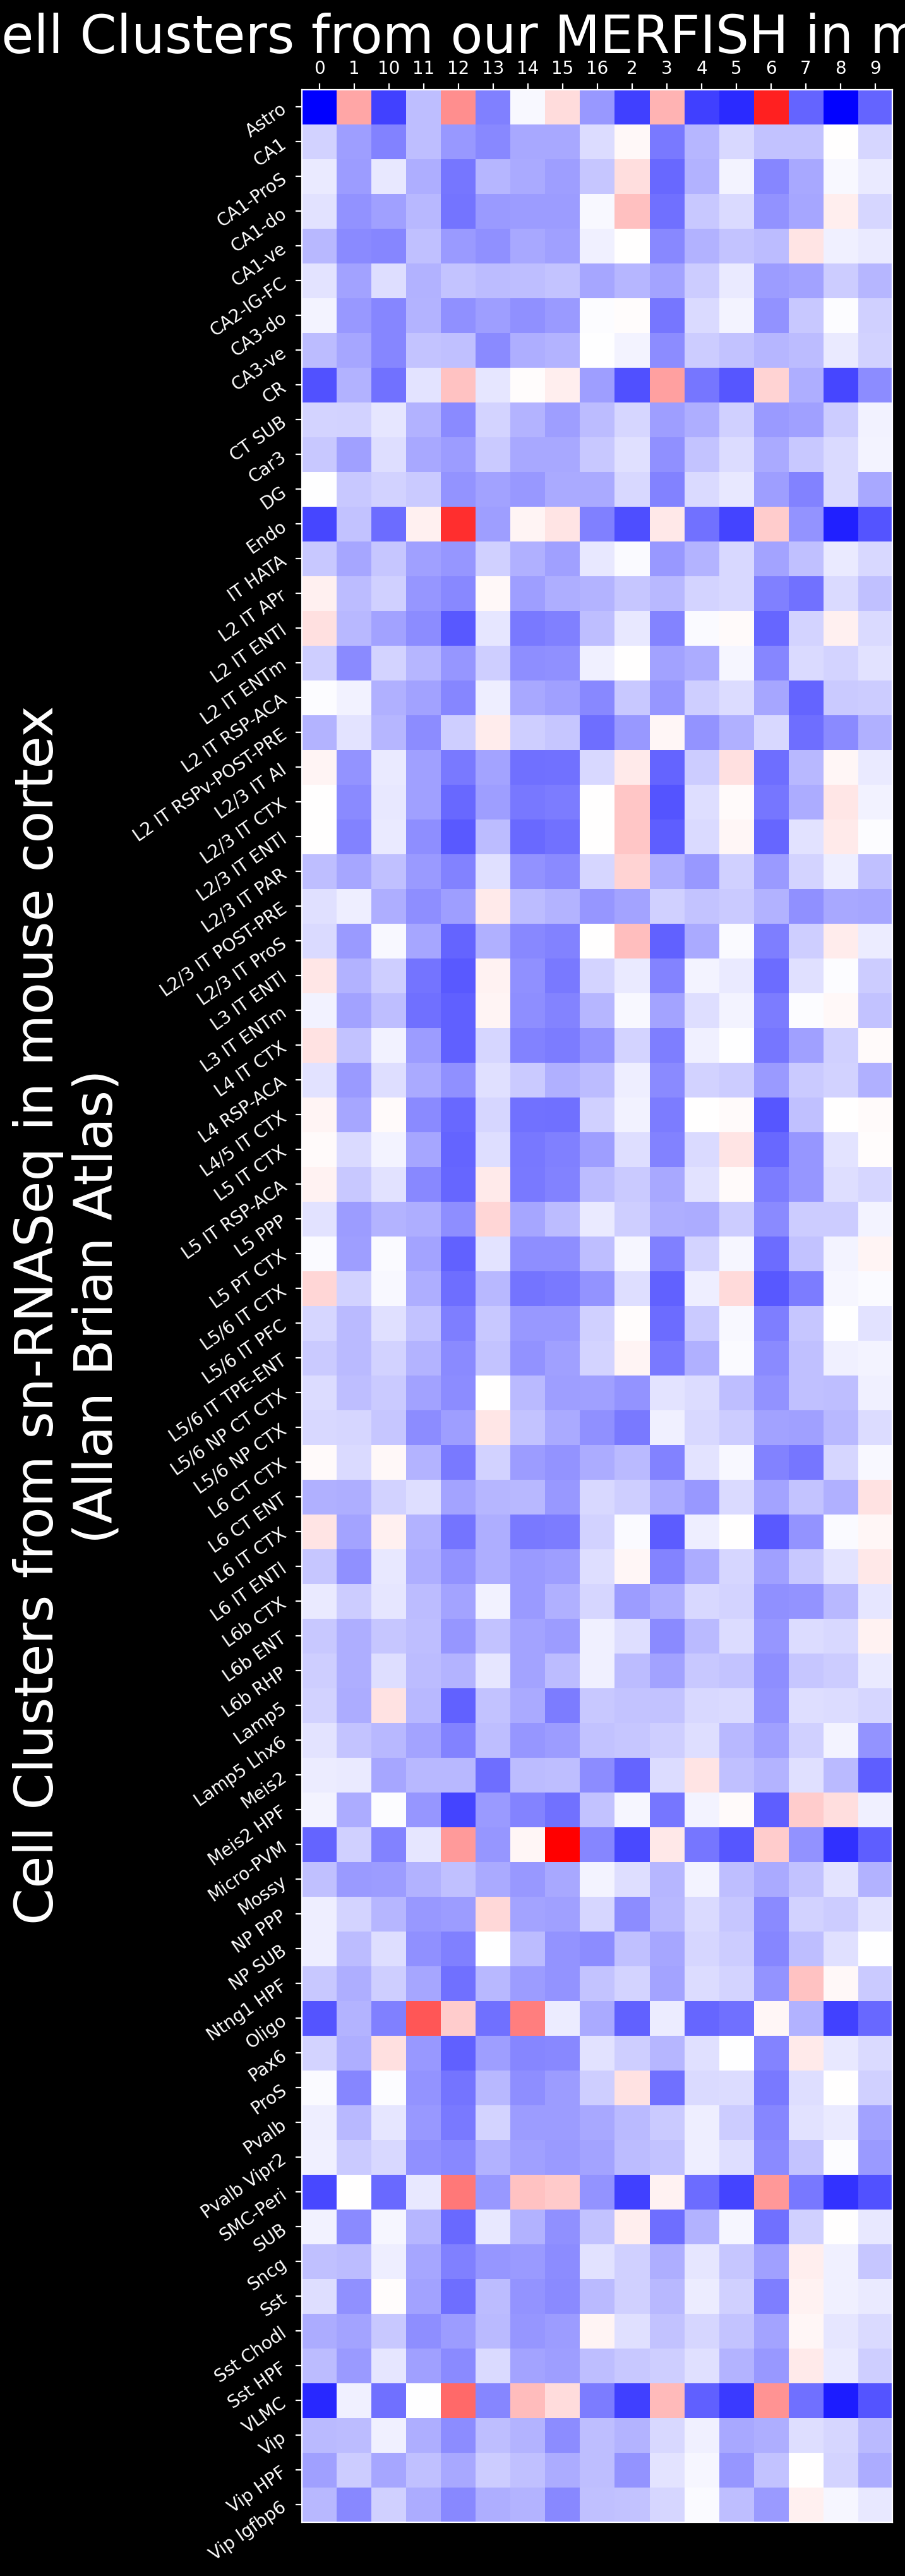

In [70]:
generate_cell_type(edu_pos_scdata, aba)

In [71]:
edu_pos_ob_cluster_name_mapping = {
    '0': 'IT CTX',
    '1': 'Astro',
    '2': 'IT ProS',
    '3': 'CR / VLMC',
    '4': 'Meis2',
    '5': 'IT',
    '6': 'Astro',
    '7': 'Ntng1 HPF',
    '8': 'IT',
    '9': 'L6 CT ENT',
    '10': 'Pax6',
    '11': 'Oligo',
    '12': 'Endo',
    '13': 'NP PPP',
    '14': 'Oligo',
    '15': 'Micro-PVM',
    '16': 'CLUSTER 16'
}

### Map cell type to leiden clustering

In [72]:
# Convert category keys in the dictionary to strings
edu_pos_cluster_name_mapping = {str(k): v for k, v in edu_pos_ob_cluster_name_mapping.items()}

# Map cluster IDs to cluster names using the updated dictionary
edu_pos_scdata.obs['cluster_names'] = edu_pos_scdata.obs['leiden'].astype(str).map(edu_pos_cluster_name_mapping)

In [73]:
edu_pos_scdata

AnnData object with n_obs × n_vars = 5143 × 275
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'edu_median', 'edu_mean', 'edu_pos', 'leiden', 'celltype', 'x', 'cluster_names'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'leiden', 'log1p', 'neighbors', 'umap', 'x_colors', 'pca', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_raw', 'X_spatial', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Generate adata file

### Generate color dict

In [74]:
edu_pos_celltype_list = list(edu_pos_scdata.obs['cluster_names'].unique())
len(edu_pos_celltype_list)

14

In [75]:
edu_pos_color_dict =  {
        "0": "#07ba7f",
        "1": "#00FF00",
        "2": "#0000FF",
        "3": "#7B68EE",
        "4": "#00FFFF",
        "5": "#FFFF00",
        "6": "#FF00FF",
        "7": "#FF7A00",
        "8": "#008080",
        "9": "#800000",
        "10": "#008000",
        "11": "#000080",
        "12": "#808080",
        "13": "#C0C0C0",
        "14": "#FFA500"
}

In [76]:
edu_pos_color_list = edu_pos_color_dict.values()
edu_pos_color_list

dict_values(['#07ba7f', '#00FF00', '#0000FF', '#7B68EE', '#00FFFF', '#FFFF00', '#FF00FF', '#FF7A00', '#008080', '#800000', '#008000', '#000080', '#808080', '#C0C0C0', '#FFA500'])

In [77]:
import json
edu_pos_dict = {}
for celltype, color in zip(edu_pos_celltype_list, edu_pos_color_list):
    edu_pos_dict[celltype] = color
edu_pos_dict = json.dumps(edu_pos_dict)
edu_pos_dict

'{"Oligo": "#07ba7f", "CLUSTER 16": "#00FF00", "Astro": "#0000FF", "Meis2": "#7B68EE", "CR / VLMC": "#00FFFF", "Endo": "#FFFF00", "IT ProS": "#FF00FF", "Ntng1 HPF": "#FF7A00", "IT CTX": "#008080", "Pax6": "#800000", "IT": "#008000", "L6 CT ENT": "#000080", "Micro-PVM": "#808080", "NP PPP": "#C0C0C0"}'

In [85]:
adata_4_week_ob_edu_pos = Jenie(edu_pos_scdata, 'edu_pos_scdata', 'edu_pos_scdata', pallete = 'edu_pos_4_week_ob')

In [86]:
adata_4_week_ob = Jenie(edu_4_week_ob_scdata, 'edu_4_week_ob_scdata', 'edu_4_week_ob_scdata', pallete = 'edu_4_month_ob')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


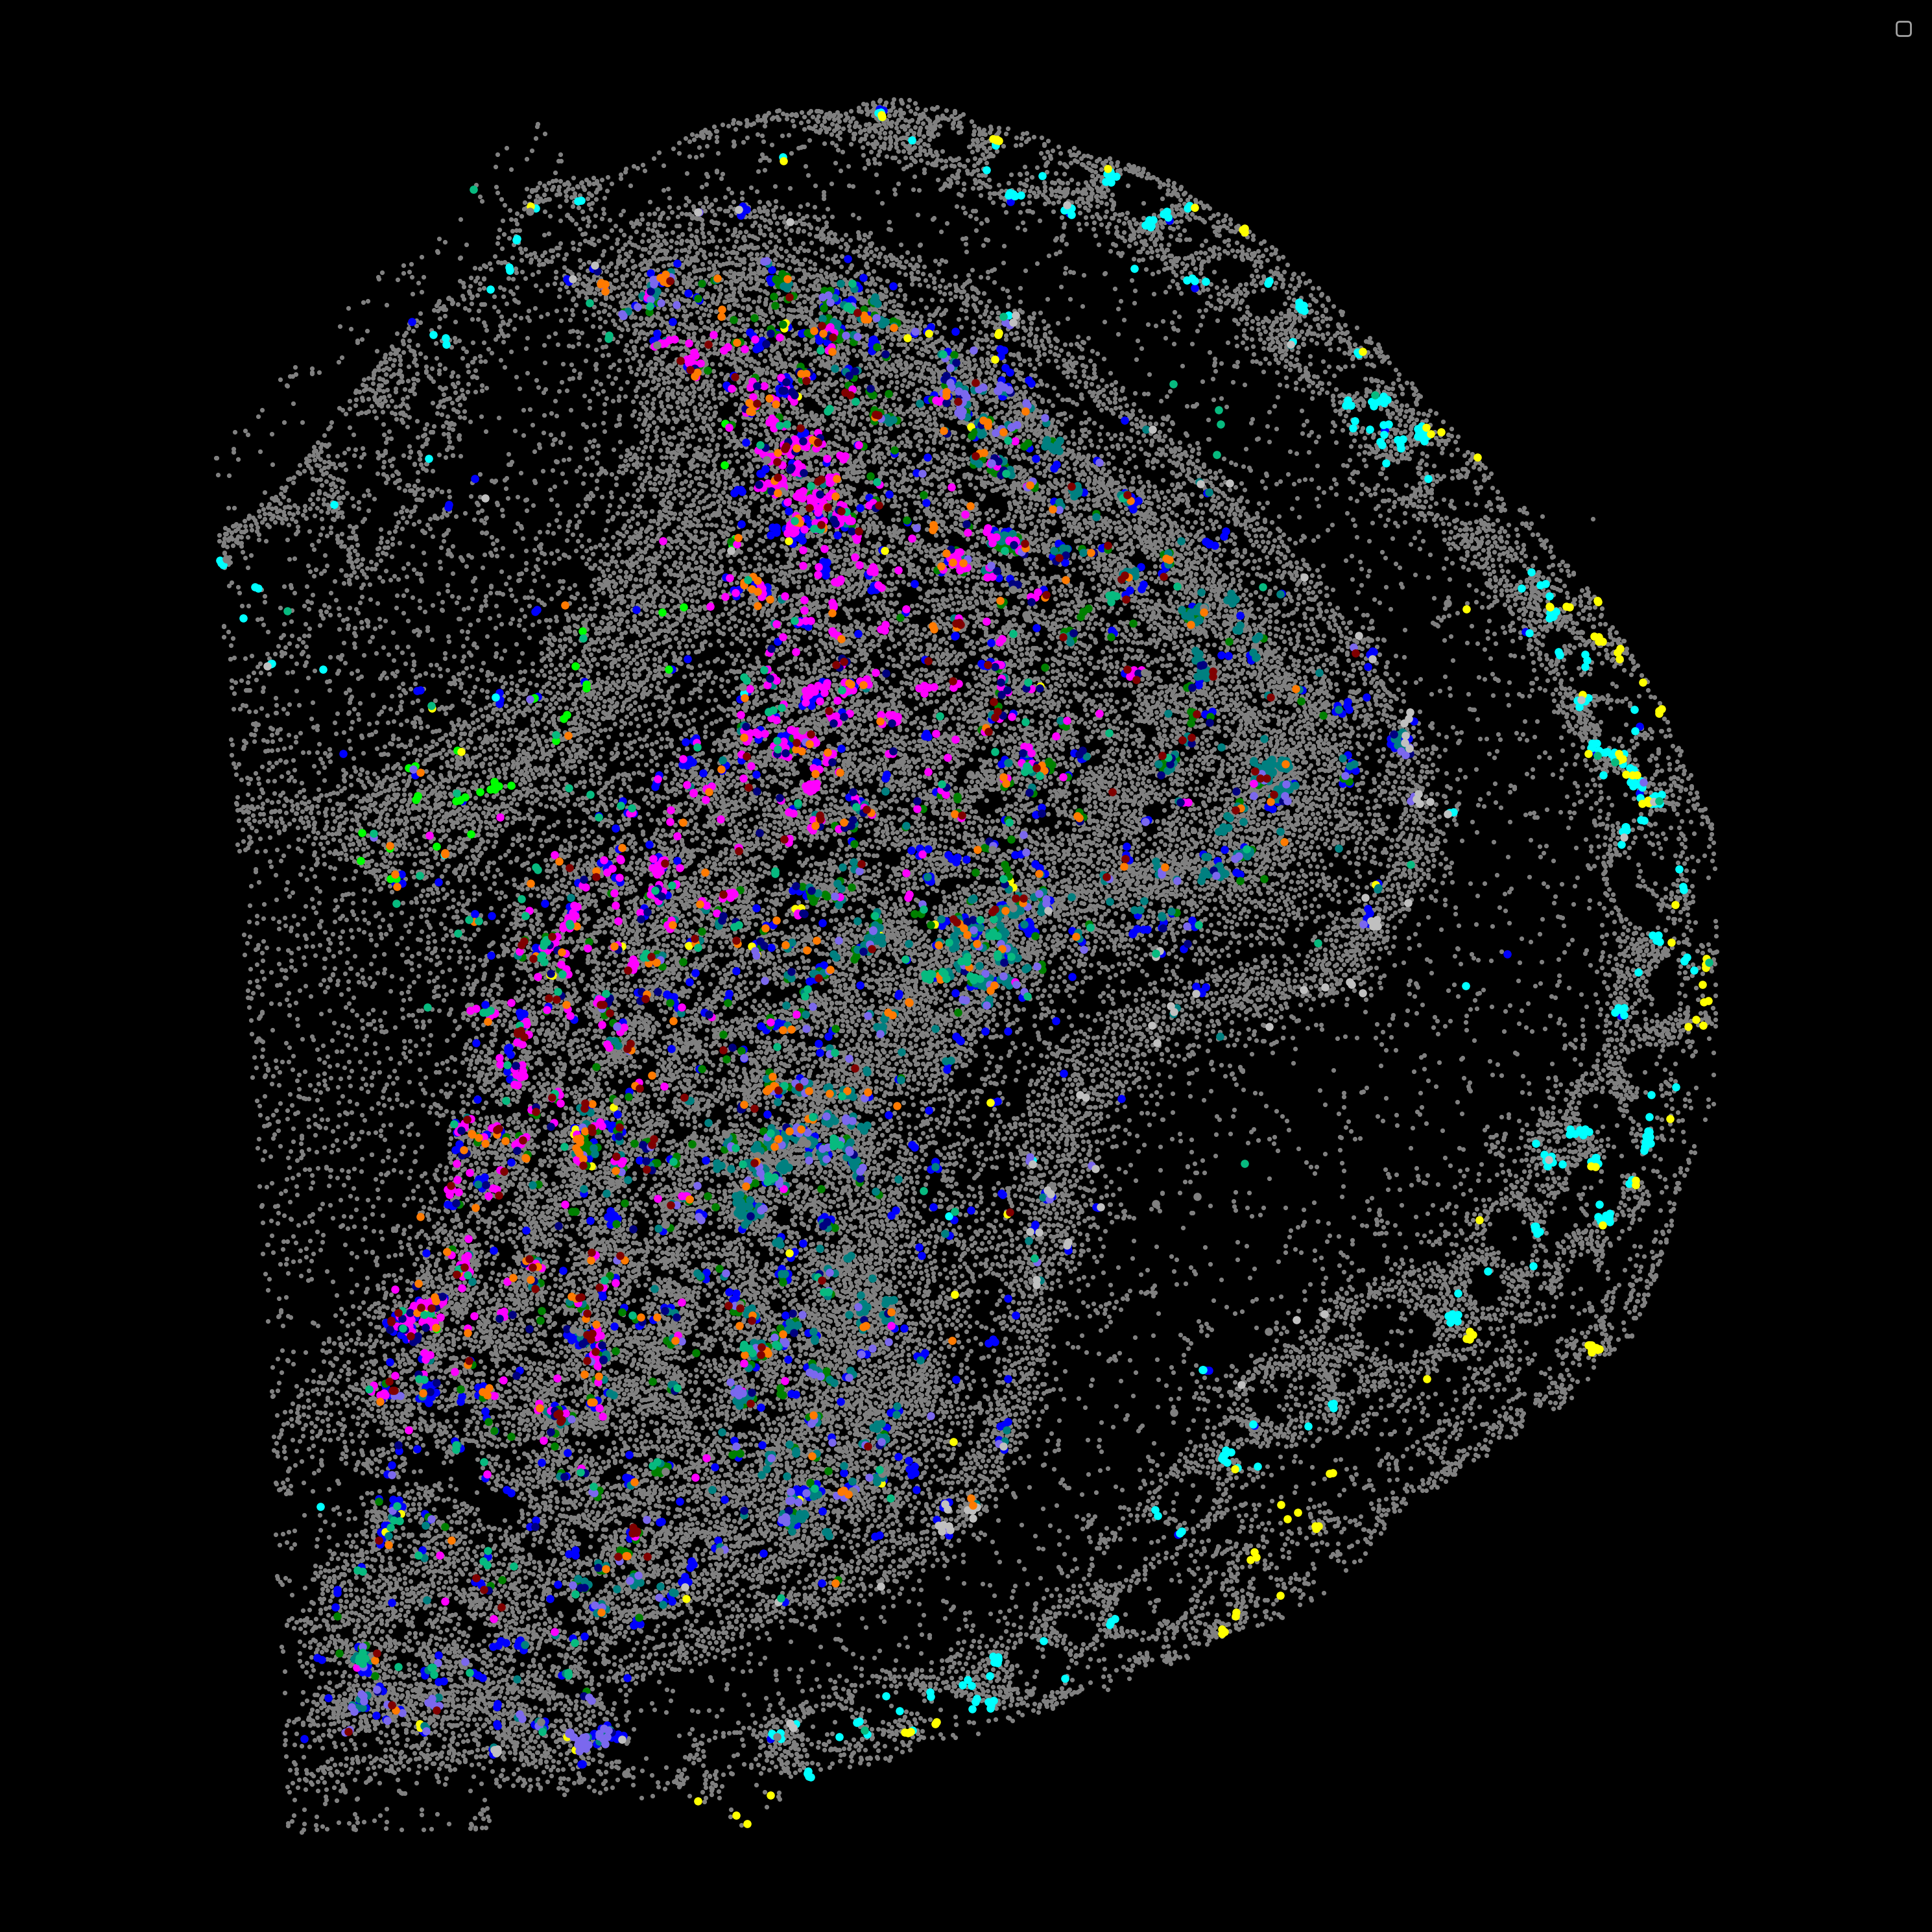

In [91]:
adata_4_week_ob_edu_pos.plot_cluster_scdata(group = 'cluster_names', ref = adata_4_week_ob, sbig = 50, ssm = 10)

In [ ]:
for cluster in adata_4_week_ob_edu_pos.obs['cluster_names'].unique():
    adata_4_week_ob_edu_pos.plot_cluster_scdata(group = 'cluster_names', clusters = [cluster],  ref = adata_4_week_ob, sbig = 50, ssm = 10)
    plt.title(f'Edu Positi {cluster} brain projection map')